## Importing Required Libraries


In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Loading Dataset


In [2]:
file_path = './Data/tweet_emotions.csv'  # Update this path to your file location
df = pd.read_csv(file_path)

## Exploratory Data Analysis (EDA)


In [3]:
df.info

<bound method DataFrame.info of          tweet_id   sentiment  \
0      1956967341       empty   
1      1956967666     sadness   
2      1956967696     sadness   
3      1956967789  enthusiasm   
4      1956968416     neutral   
...           ...         ...   
39995  1753918954     neutral   
39996  1753919001        love   
39997  1753919005        love   
39998  1753919043   happiness   
39999  1753919049        love   

                                                 content  
0      @tiffanylue i know  i was listenin to bad habi...  
1      Layin n bed with a headache  ughhhh...waitin o...  
2                    Funeral ceremony...gloomy friday...  
3                   wants to hang out with friends SOON!  
4      @dannycastillo We want to trade with someone w...  
...                                                  ...  
39995                                   @JohnLloydTaylor  
39996                     Happy Mothers Day  All my love  
39997  Happy Mother's Day to all the mom

In [6]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [7]:
df.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [8]:
df['sentiment'].value_counts()

sentiment
neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: count, dtype: int64

In [9]:
df['content'].sample(5)

33017    @mattlogelin mankini!! i'm not sure i'd recogn...
26476    @mamalou52 I love Puerto Rico also,been all ov...
7526     @ArnaudJacobs haha well i was at my friend's p...
28125    today got her POP! t-shirt &amp; lovess ittt  ...
14327    @Impala_Guy In the past it was ok but since iï...
Name: content, dtype: object

## Data Preprocessing


In [16]:
import spacy

# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

# Function to preprocess text using spaCy
def preprocess_text_spacy(text):
    doc = nlp(text.lower())  # Convert to lowercase and tokenize
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and not token.is_digit]  # Remove stopwords, punctuation, and digits
    return ' '.join(tokens)

# Apply preprocessing to content
df['processed_content'] = df['content'].apply(preprocess_text_spacy)



0    @tiffanylue know   listenin bad habit earlier ...
1                 layin n bed headache   ughhhh waitin
2                       funeral ceremony gloomy friday
3                              wants hang friends soon
4            @dannycastillo want trade houston tickets
Name: processed_content, dtype: object

In [18]:
# Display the processed content
df['content'].head()

0    @tiffanylue i know  i was listenin to bad habi...
1    Layin n bed with a headache  ughhhh...waitin o...
2                  Funeral ceremony...gloomy friday...
3                 wants to hang out with friends SOON!
4    @dannycastillo We want to trade with someone w...
Name: content, dtype: object

In [17]:
# Display the processed content
df['processed_content'].head()

0    @tiffanylue know   listenin bad habit earlier ...
1                 layin n bed headache   ughhhh waitin
2                       funeral ceremony gloomy friday
3                              wants hang friends soon
4            @dannycastillo want trade houston tickets
Name: processed_content, dtype: object

## Spliting the Data


In [19]:
X = df['processed_content']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
max_words = 10000
max_len = 100

In [21]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

## Building the Model


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Build the model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(y.unique()), activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


d:\DeepLearning\Advanced NLP Sentiment Analysis and Emotion Detection\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Training the Model


In [26]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_train_encoded, y_test_encoded = train_test_split(y_encoded, test_size=0.2, random_state=42)


In [27]:
# Train the model
history = model.fit(X_train_pad, y_train_encoded, epochs=10, validation_split=0.1, batch_size=32)

Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 63s 69ms/step - accuracy: 0.2297 - loss: 2.1775 - val_accuracy: 0.3137 - val_loss: 2.0104
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 65s 72ms/step - accuracy: 0.3684 - loss: 1.8951 - val_accuracy: 0.3206 - val_loss: 1.9634
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 60s 67ms/step - accuracy: 0.4232 - loss: 1.7490 - val_accuracy: 0.3231 - val_loss: 1.9987
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 61s 68ms/step - accuracy: 0.4758 - loss: 1.6081 - val_accuracy: 0.3237 - val_loss: 2.0537
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 62s 68ms/step - accuracy: 0.5330 - loss: 1.4722 - val_accuracy: 0.3116 - val_loss: 2.1405
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.5835 - loss: 1.3277 - val_accuracy: 0.2978 - val_loss: 2.3457
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 79s 88ms/step - accuracy: 0.6228 - loss: 1.1956 - val_accuracy: 0.2934 - val_loss: 2.5218
Epoch 8/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 68s 75ms/step - accuracy: 0.6553 - loss: 1.0851 - 

## Evaluating The Model


In [28]:
loss, accuracy = model.evaluate(X_test_pad, y_test_encoded)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.2865 - loss: 3.0950
Test Loss: 3.1532182693481445
Test Accuracy: 0.2837499976158142


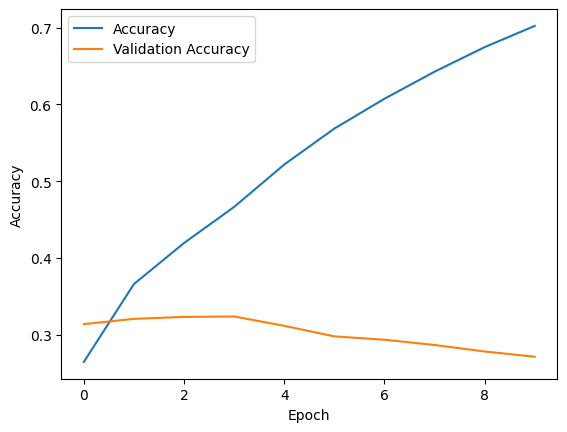

In [30]:
# Plot training history
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show() 

In [34]:
# Save the entire model to a file
model.save('sentiment_analysis_model.h5')


In [35]:
from tensorflow.keras.models import load_model

# Load the model from file
loaded_model = load_model('sentiment_analysis_model.h5')


In [37]:

def preprocess_text_spacy(text):
    doc = nlp(text.lower())  # Convert to lowercase and tokenize
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and not token.is_digit]  # Remove stopwords, punctuation, and digits
    return ' '.join(tokens)

new_tweet = "well this is too bad i am going to die"
new_tweet_processed = preprocess_text_spacy(new_tweet)

new_tweet_seq = tokenizer.texts_to_sequences([new_tweet_processed])
new_tweet_pad = pad_sequences(new_tweet_seq, maxlen=max_len)

predicted_class = loaded_model.predict(new_tweet_pad)

predicted_label = label_encoder.inverse_transform([predicted_class.argmax()])

print(f"Predicted sentiment: {predicted_label[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted sentiment: worry
